# **Skin Scan**

# **1. Background**

## Problem Statement

Skin cancer is one of the most common types of cancer, and finding it early makes treatment much more effective. Doctors usually start with a basic visual exam, and if something looks concerning, they might use dermoscopy for a closer look, take a biopsy, and examine the tissue under a microscope. The challenge with automating this process is that skin lesions can be hard to distinguish. Lesions of the same type do not always look alike, and different types can appear very similar. Even experienced doctors sometimes have trouble classifying them, which is why machine learning could be a powerful tool for improving detection.


This project trains a machine learning model to
classify skin lesions into seven categories:

* **Actinic keratoses (akiec):** Precancerous lesions.

* **Basal cell carcinoma (bcc):** A slow-growing skin cancer.

* **Benign keratosis (bkl):** Non-cancerous growths.

* **Dermatofibroma (df):** A harmless, firm nodule.

* **Melanoma (mel):** A dangerous, fast-spreading cancer.

* **Melanocytic nevi (nv):** Common moles, mostly benign.

* **Vascular lesions (vasc):** Blood vessel abnormalities.





## Dataset Overview

The **HAM10000** dataset, available on [Kaggle](https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000), contains 10015 dermatoscopic images labeled across seven categories. It is publicly accessible through the ISIC archive and includes images from diverse sources, covering different lighting conditions, skin types, and imaging devices. This variety makes it a strong benchmark for developing machine learning models that can handle real-world variability in skin lesion classification.

## Model Overview (CNN)

The **Convolutional Neural Network (CNN)** is a deep learning model designed to process image data, making it perfect for tasks like detecting skin cancer from images. The model works by detecting patterns and features in images through several key layers.

<br>

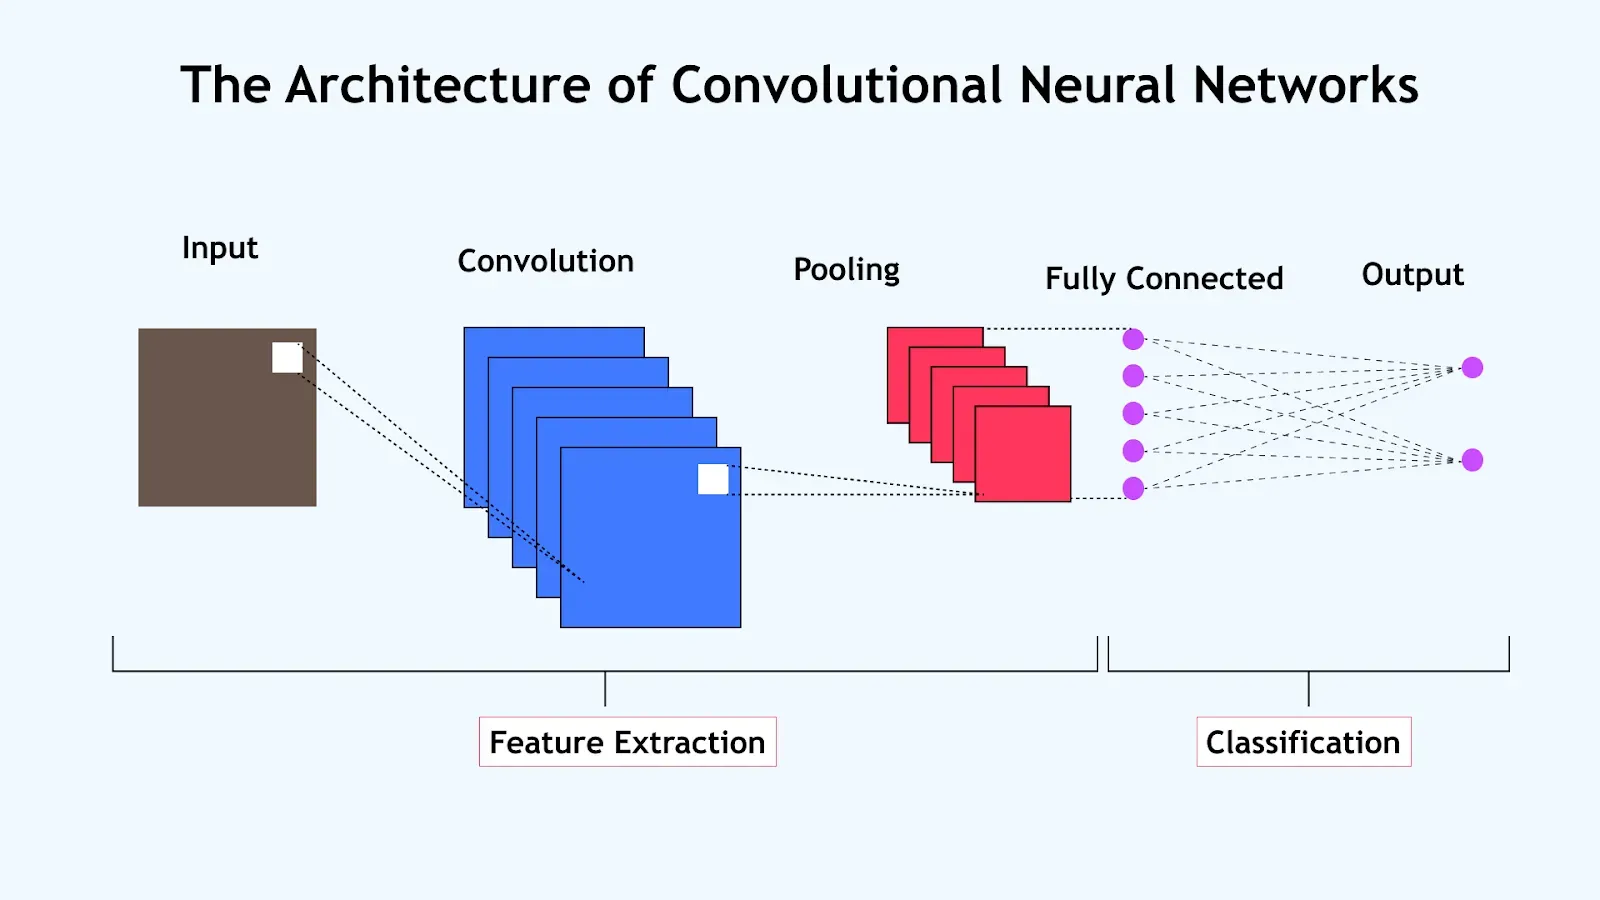



1.   **Convolutional Layers:** Detect basic features like edges and textures by applying filters to small parts of the image.

2.   **ReLU Activation:** Removes negative values from the feature maps, keeping only useful information.

3.   **Pooling Layers:** Reduce the image size by focusing on the most important details (like using the max value in small sections).

4.   **Fully Connected Layers:** Flatten the data into a single list, then use it to make the final decision about the image.

5.   **Output Layer:** Gives a probability for each class (e.g., cancerous or not) using softmax or sigmoid.


#**2. Imports**

In [30]:
import numpy as np
import pandas as pd
import os
from glob import glob
from google.colab import drive
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from keras.regularizers import l2
from keras.optimizers import Adam, Adamax
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
drive.mount('/content/drive')

image_dir = '/content/drive/MyDrive/ML_Dataset'

Mounted at /content/drive


# **3. Data Preprocessing**

## Reading Dataset Metadata

In [5]:
lesion_df = pd.read_csv(image_dir + '/metadata/HAM10000_metadata.csv')

# lesion_df.info()

## Reading Lesion Images

In [6]:
# lesion_dict is a dictionary that displays more human friendly labels
lesion_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoseas',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [7]:
# imageid_path_dict is a dictionary that maps image id to the full path of the image
# it merges the 2 images directories into a single dictionary
imageid_path_dict = {
    os.path.splitext(os.path.basename(x))[0]: x
    for x in glob(os.path.join(image_dir + '/images', '*', '*.jpg'))
}

len(imageid_path_dict)

10015

## Feature Manipulataion & Set Up


**Creating new columns in the Dataframe for clearer Features**
*   path column represents the file path to a given image
*   lesion_type is the human friendly legion representation (done using the lesion_dict dictionary)
*   lesion_type_id is the corresponding index in the lesion_dict





In [8]:
lesion_df['path'] = lesion_df['image_id'].map(imageid_path_dict.get)
lesion_df['lesion_type'] = lesion_df['dx'].map(lesion_dict.get)
lesion_df['lesion_type_id'] = pd.Categorical(lesion_df['lesion_type']).codes

# df.head()

In [9]:
lesion_df['image'] = lesion_df['path'].map(lambda image_path: np.asarray(Image.open(image_path).resize((100,75))))

# **4. Data Cleaning**

## Removing NULL fields

Checking for missing/null datatype for each of the fields in the Dataset

In [10]:
lesion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   lesion_id       10015 non-null  object 
 1   image_id        10015 non-null  object 
 2   dx              10015 non-null  object 
 3   dx_type         10015 non-null  object 
 4   age             9958 non-null   float64
 5   sex             10015 non-null  object 
 6   localization    10015 non-null  object 
 7   path            10015 non-null  object 
 8   lesion_type     10015 non-null  object 
 9   lesion_type_id  10015 non-null  int8   
 10  image           10015 non-null  object 
dtypes: float64(1), int8(1), object(9)
memory usage: 792.3+ KB


As we can see there are a total of 10015 records/entries

Most columns are non-null to that exact number of 10015 except age with 9958/10015 records being non-null

In [11]:
lesion_df.isnull().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,57
sex,0
localization,0
path,0
lesion_type,0
lesion_type_id,0


As shown above we can see that 57 records have age set to NULL

We will replace these values with the mean of all existing ages in the Dataset

In [12]:
lesion_df['age'] = lesion_df['age'].fillna(lesion_df['age'].mean())


After checking again we can see that there are no more NULL values in the dataset

In [13]:
lesion_df.isnull().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,0
sex,0
localization,0
path,0
lesion_type,0
lesion_type_id,0


# **5. Exploratory Data Analysis (EDA)**



In [14]:
lesion_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,lesion_type,lesion_type_id,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/ML_Dataset/images/HAM10...,Benign keratosis-like lesions,2,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/ML_Dataset/images/HAM10...,Benign keratosis-like lesions,2,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/ML_Dataset/images/HAM10...,Benign keratosis-like lesions,2,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/ML_Dataset/images/HAM10...,Benign keratosis-like lesions,2,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/MyDrive/ML_Dataset/images/HAM10...,Benign keratosis-like lesions,2,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."


## Gender Distribution

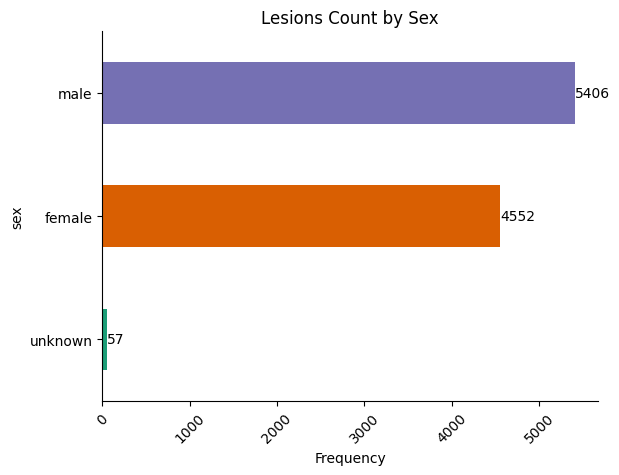

In [15]:
counts = lesion_df.groupby('sex').size().sort_values(ascending=True)

ax = counts.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
ax.set_title('Lesions Count by Sex')
ax.set_xlabel('Frequency')

plt.gca().spines[['top', 'right']].set_visible(False)

for p in ax.patches:
    ax.annotate(f'{p.get_width()}',
                (p.get_width() + 0.2, p.get_y() + p.get_height() / 2),
                ha='left', va='center')

plt.xticks(rotation=45)

plt.show()

## Lesion Type Distribution

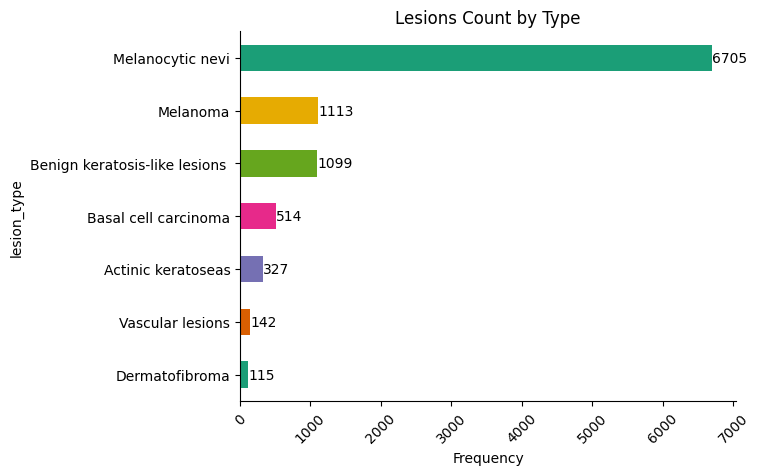

In [16]:
counts = lesion_df.groupby('lesion_type').size().sort_values(ascending=True)

ax = counts.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
ax.set_title('Lesions Count by Type')
ax.set_xlabel('Frequency')

plt.gca().spines[['top', 'right']].set_visible(False)

for p in ax.patches:
    ax.annotate(f'{p.get_width()}',
                (p.get_width() + 0.2, p.get_y() + p.get_height() / 2),
                ha='left', va='center')
plt.xticks(rotation=45)

plt.show()

## Localization Distribution

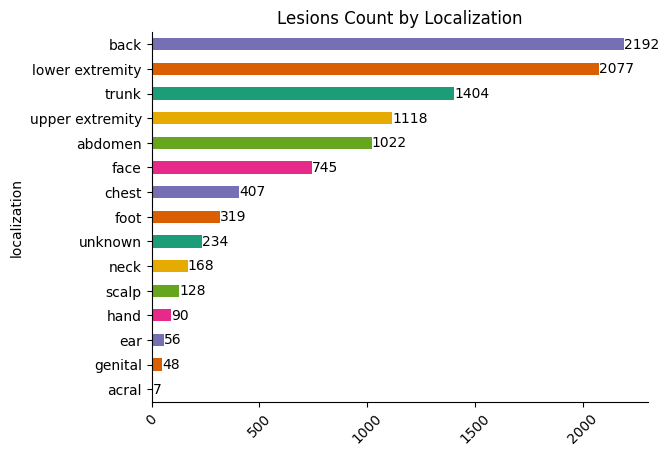

In [17]:
counts = lesion_df.groupby('localization').size().sort_values(ascending=True)

ax = counts.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
ax.set_title('Lesions Count by Localization')
plt.gca().spines[['top', 'right']].set_visible(False)

for p in ax.patches:
    ax.annotate(f'{p.get_width()}',
                (p.get_width() + 0.2, p.get_y() + p.get_height() / 2),
                ha='left', va='center')

plt.xticks(rotation=45)

plt.show()


## Diagnosis Distribution

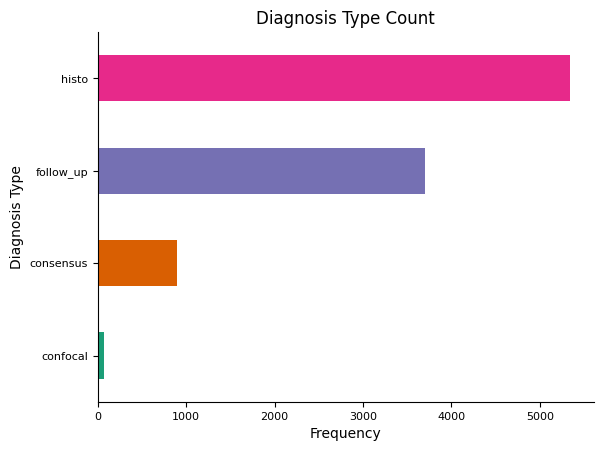

In [18]:
lesion_df['dx_type'].value_counts().sort_values(ascending=True).plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))

plt.title('Diagnosis Type Count', fontsize=12)
plt.xlabel('Frequency', fontsize=10)
plt.ylabel('Diagnosis Type', fontsize=10)

plt.gca().spines[['top', 'right']].set_visible(False)

plt.yticks(rotation=0, fontsize=8)
plt.xticks(fontsize=8)

plt.show()


## Age Distribution

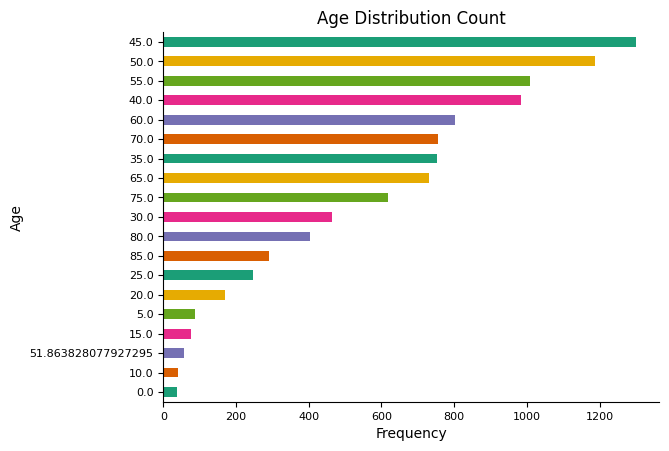

In [19]:
lesion_df['age'].value_counts().sort_values(ascending=True).plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))

plt.title('Age Distribution Count', fontsize=12)
plt.xlabel('Frequency', fontsize=10)
plt.ylabel('Age', fontsize=10)

plt.gca().spines[['top', 'right']].set_visible(False)

plt.yticks(rotation=0, fontsize=8)
plt.xticks(fontsize=8)

plt.show()


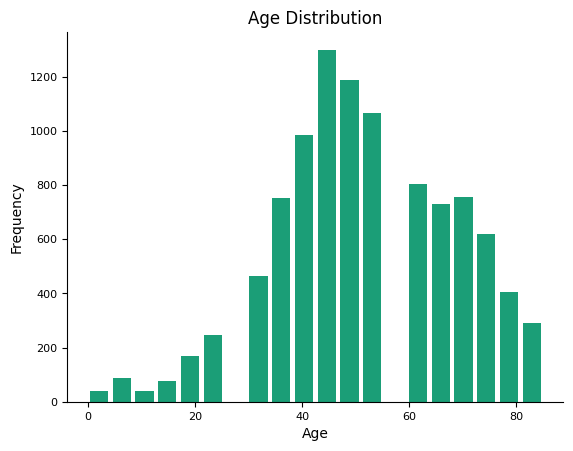

In [20]:
lesion_df['age'].plot(kind='hist', bins=20, color=sns.color_palette('Dark2')[0], rwidth=0.8)

plt.title('Age Distribution', fontsize=12)
plt.xlabel('Age', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

plt.gca().spines[['top', 'right']].set_visible(False)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()


# **6. Data Model**


## Features and Target Variables (Labels)

In [21]:
X = lesion_df.drop(columns=['lesion_type_id'],axis=1) # Features
y = lesion_df['lesion_type_id'] # Target

## Data Split (Training & Test)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 11)

## Image Normalization

**Z-score normalization**
<br><br>
$
X_{\text{std}} = \frac{X - \mu}{\sigma}
$

- $X_{\text{std}}$ = standardized pixel value  
- $X$ = original pixel value  
- $μ$ = mean of all pixel values  
- $\sigma$ = standard deviation of all pixel values

<br>


In [23]:
X_train_arr = np.asarray(X_train['image'].tolist())

X_train_mean = np.mean(X_train_arr)
X_train_std = np.std(X_train_arr)

X_train = (X_train_arr - X_train_mean) / X_train_std


X_test_arr = np.asarray(X_test['image'].tolist())
X_test_mean = np.mean(X_test_arr)
X_test_std = np.std(X_test_arr)

X_test = (X_test_arr - X_test_mean) / X_test_std

## Label Encoding

**One-hot encoding** is a method used to convert categorical labels (like class labels) into a binary format
* This makes it easier for our model handle processing the data

In [24]:
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

## Data Split (Validation & Testing)

In [25]:
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = 0.1, random_state = 22)

In [26]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
X_train = X_train.reshape(X_train.shape[0], *(75, 100, 3))
X_test = X_test.reshape(X_test.shape[0], *(75, 100, 3))


## CNN Model

###Model Structure

In [27]:
# input_shape = (75, 100, 3)
# num_classes = 7

# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
# model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
# model.add(MaxPool2D(pool_size = (2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
# model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.40))

# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))
# model.summary()

input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()

# Feature Extraction
model.add(Conv2D(32, (3, 3), activation='relu', padding='Same', input_shape=input_shape, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='Same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='Same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='Same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Classifier
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 75, 100, 32)         │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 75, 100, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 100, 32)         │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 100, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 37, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 37, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 50, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 37, 50, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 37, 50, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 18, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 18, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,559 (295.15 KB)

 Trainable params: 75,175 (293.65 KB)

 Non-trainable params: 384 (1.50 KB)


<br>

###Optimizer Configuration and Model Checkpointing


This code sets up the optimizer, compiles the model, and defines a checkpoint to save the best model during training.
* **Adam Optimizer** – A smart optimizer that automatically adjusts how much the model’s weights change during training, so the model can learn more efficiently.
* **Categorical Cross-Entropy Loss** – A way to measure how far off the model’s predictions are from the actual labels when you’re working with multiple classes.
* **Model Checkpoint** – A feature that saves the model whenever it performs the best on the validation data, so you can keep the best version and avoid overfitting.

In [28]:
# Define the optimizer (Adam is an adaptive learning rate optimization algorithm)
optimizer = Adam(learning_rate=0.001)  # Learning rate controls how much weights update during training

# Compile the model with loss function and evaluation metric
model.compile(
    optimizer=optimizer,                # Optimizer responsible for adjusting model weights
    loss="categorical_crossentropy",    # Loss function for multi-class classification
    metrics=["accuracy"]                # Track accuracy during training
)

# Define a checkpoint to save the best model
learning_rate_reduction = ModelCheckpoint(
    filepath='best_model.h5',  # Filepath to save the best model weights
    monitor='val_acc',         # Monitor validation accuracy to determine the best model
    mode='max',                # Save the model when validation accuracy is at its highest
    verbose=1,                 # Print updates when a new best model is saved
    save_best_only=True        # Only save models that improve performance
)

<br>

###Data Augmentation

**ImageDataGenerator** is a tool for data augmentation that slightly alters images during training. It applies random rotations, zooming, and shifts to introduce variation, helping the model generalize better and avoid overfitting. By making small, random changes to the images, the model learns patterns instead of memorizing specific images, improving its ability to classify new data.

In [31]:
datagen = ImageDataGenerator(
        featurewise_center=False,             # Don't normalize based on the dataset mean (no feature-wise centering)
        samplewise_center=False,              # Don't normalize each image individually (no sample-wise centering)
        featurewise_std_normalization=False,  # No standard deviation normalization for the dataset (no feature-wise std normalization)
        samplewise_std_normalization=False,   # No standard deviation normalization per image (no sample-wise std normalization)
        zca_whitening=False,                  # No ZCA whitening applied (no decorrelation of pixel values)
        rotation_range=10,                    # Rotate images randomly by up to 10 degrees (data augmentation)
        zoom_range=0.1,                       # Apply random zooming up to 10% (data augmentation)
        width_shift_range=0.1,                # Shift images horizontally by up to 10% (data augmentation)
        height_shift_range=0.1,               # Shift images vertically by up to 10% (data augmentation)
        horizontal_flip=False,                # No horizontal flipping (no left-right mirroring)
        vertical_flip=False)                  # No vertical flipping (no upside-down mirroring)

# Computes any necessary statistics from training data
datagen.fit(X_train)

<br>

###Training Model

In [33]:
epochs = 150     # Number of times the model will go through the entire dataset
batch_size = 60  # Number of samples per training step

# Fit the model with the augmented data and training settings
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),  # Flow method generates batches of augmented images
    epochs=epochs,                                          # Train for the specified number of epochs
    validation_data=(X_validate, y_validate),               # Use validation data for evaluating the model after each epoch
    verbose=1,                                              # Print progress during training (1 means show a progress bar)
    steps_per_epoch=X_train.shape[0] // batch_size,         # Number of steps per epoch (total samples divided by batch size)
    callbacks=[learning_rate_reduction]                     # Apply the learning rate reduction callback to save the best model
)

Epoch 1/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 380s 3s/step - accuracy: 0.6931 - loss: 0.9147 - val_accuracy: 0.7357 - val_loss: 0.8365
Epoch 2/150
  1/120 ━━━━━━━━━━━━━━━━━━━━ 5:07 3s/step - accuracy: 0.7000 - loss: 0.8921

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.7000 - loss: 0.8921 - val_accuracy: 0.7357 - val_loss: 0.8371
Epoch 3/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 368s 3s/step - accuracy: 0.7002 - loss: 0.8892 - val_accuracy: 0.7369 - val_loss: 0.8114
Epoch 4/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.7333 - loss: 0.8663 - val_accuracy: 0.7382 - val_loss: 0.8130
Epoch 5/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 360s 3s/step - accuracy: 0.7029 - loss: 0.8796 - val_accuracy: 0.7257 - val_loss: 0.7938
Epoch 6/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.6333 - loss: 0.8926 - val_accuracy: 0.7307 - val_loss: 0.7965
Epoch 7/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 360s 3s/step - accuracy: 0.6962 - loss: 0.8857 - val_accuracy: 0.7344 - val_loss: 0.7960
Epoch 8/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.6167 - loss: 0.9852 - val_accuracy: 0.7369 - val_loss: 0.8016
Epoch 9/150
120/120 ━━━━━━━━━━━━━━━━━━━━ 372s 3s/step - accuracy: 0.7042 - loss: 0.8585 - val_accu

<br>

###Model Accurary Plot

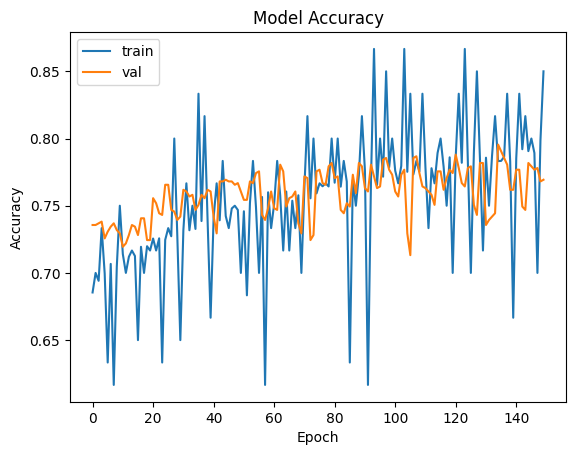

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

<br>

###Model Loss Plot

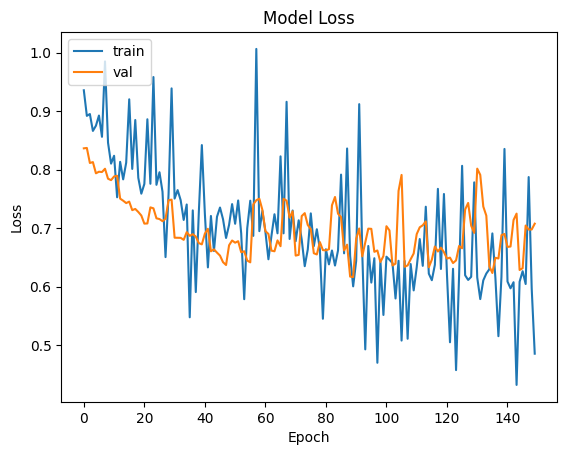

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [37]:
model.save("skin_scan_model.keras")